# *Introduction*

# Build the environment

In [ ]:
# Install TerraTorch and dependencies
!pip install terratorch
!pip install gdown tensorboard lightning

In [ ]:
import os
import shutil
from pathlib import Path
import numpy as np
from PIL import Image
import torch
import gdown
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from terratorch.datamodules import GenericNonGeoClassificationDataModule
from terratorch.tasks import ClassificationTask
import rasterio
import zipfile
import warnings
warnings.filterwarnings("ignore")

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATASET_ZIP = "/content/drive/MyDrive/GFM/Data_Romania.zip"

if not os.path.exists(DATASET_ZIP):
    raise FileNotFoundError(f"Dataset not found at {DATASET_ZIP}")

# Extract dataset
if not os.path.exists("Data"):
    print("Extracting dataset...")
    with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("✅ Extraction complete!")

# Find data root
if os.path.exists("Data"):
    DATA_ROOT = Path("Data")
elif os.path.exists("data_Romania/Data"):
    DATA_ROOT = Path("data_Romania/Data")
else:
    raise ValueError("Cannot find Data folder!")

print(f"✅ DATA_ROOT: {DATA_ROOT}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting dataset...
✅ Extraction complete!
✅ DATA_ROOT: Data


In [ ]:
PREPARED_ROOT = Path("./prepared")
TRAIN_DIR = PREPARED_ROOT / "train"
VAL_DIR = PREPARED_ROOT / "val"
TEST_DIR = PREPARED_ROOT / "test"
OUTPUT_PATH = "./output/terramind_romania"

# Hyperparameters
IMG_SIZE = 224
NUM_CLASSES = 10
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50
SEED = 42

pl.seed_everything(SEED)

if not TRAIN_DIR.exists():
    print("\nCreating train/val/test splits...")
    TRAIN_DIR.mkdir(parents=True, exist_ok=True)
    VAL_DIR.mkdir(parents=True, exist_ok=True)
    TEST_DIR.mkdir(parents=True, exist_ok=True)

    classes = [d for d in os.listdir(DATA_ROOT)
               if os.path.isdir(DATA_ROOT / d) and d.isdigit()]

    print(f"Found classes: {sorted(classes)}")

    for cls in classes:
        cls_path = DATA_ROOT / cls
        images = [f for f in os.listdir(cls_path)
                  if f.endswith((".jpg", ".png", ".tif"))]

        np.random.seed(42)
        np.random.shuffle(images)

        n = len(images)
        n_train = int(0.7 * n)
        n_val = int(0.2 * n)

        train_imgs = images[:n_train]
        val_imgs = images[n_train:n_train + n_val]
        test_imgs = images[n_train + n_val:]

        (TRAIN_DIR / cls).mkdir(exist_ok=True)
        (VAL_DIR / cls).mkdir(exist_ok=True)
        (TEST_DIR / cls).mkdir(exist_ok=True)

        for img in train_imgs:
            shutil.copy(cls_path / img, TRAIN_DIR / cls / img)
        for img in val_imgs:
            shutil.copy(cls_path / img, VAL_DIR / cls / img)
        for img in test_imgs:
            shutil.copy(cls_path / img, TEST_DIR / cls / img)

        print(f"Class {cls}: {len(images)} images (train={len(train_imgs)}, val={len(val_imgs)}, test={len(test_imgs)})")

    print("✅ Dataset split created")
else:
    print("✅ Dataset split already exists")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42



Creating train/val/test splits...
Found classes: ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']
Class 10: 10 images (train=7, val=2, test=1)
Class 5: 10 images (train=7, val=2, test=1)
Class 2: 10 images (train=7, val=2, test=1)
Class 1: 10 images (train=7, val=2, test=1)
Class 4: 10 images (train=7, val=2, test=1)
Class 9: 10 images (train=7, val=2, test=1)
Class 6: 10 images (train=7, val=2, test=1)
Class 3: 10 images (train=7, val=2, test=1)
Class 8: 10 images (train=7, val=2, test=1)
Class 7: 10 images (train=7, val=2, test=1)
✅ Dataset split created


# Database Statistics

In [ ]:
all_pixels = []
num_bands = None

for cls in os.listdir(TRAIN_DIR):
    cls_folder = TRAIN_DIR / cls
    if not cls_folder.is_dir():
        continue

    for img_file in cls_folder.iterdir():
        if img_file.suffix.lower() not in ['.tif', '.tiff']:
            continue

        with rasterio.open(img_file) as src:
            img = src.read()
            if num_bands is None:
                num_bands = img.shape[0]

            # Flatten spatial dimensions
            img_flat = img.reshape(img.shape[0], -1).T
            all_pixels.append(img_flat)

if all_pixels:
    all_pixels = np.vstack(all_pixels)
    means = np.mean(all_pixels, axis=0).tolist()
    stds = np.std(all_pixels, axis=0).tolist()

    # Add a small epsilon for zero std
    stds = [max(s, 1e-6) for s in stds]
else:
    # Fallback values
    means = [0.5] * num_bands
    stds = [0.5] * num_bands

print(f"✅ Means: {means}")
print(f"✅ Stds: {stds}")
print(f"✅ Channels: {len(means)}")

✅ Means: [0.171550914645195, 0.16680072247982025, 0.15637192130088806, 0.21879059076309204, 0.09196460247039795, 0.06900493800640106, 0.0]
✅ Stds: [0.2669355273246765, 0.26427310705184937, 0.26923272013664246, 0.2533985674381256, 0.08257992565631866, 0.05996156111359596, 1e-06]
✅ Channels: 7


# Datamodule

In [ ]:
datamodule = GenericNonGeoClassificationDataModule(
    train_data_root=str(TRAIN_DIR),
    val_data_root=str(VAL_DIR),
    test_data_root=str(TEST_DIR),
    batch_size=BATCH_SIZE,
    num_workers=2,
    num_classes=NUM_CLASSES,
    means=means,
    stds=stds,
)

print("✅ DataModule created with Custom Loader")

✅ DataModule created with Custom Loader


In [ ]:
num_channels = len(means)
print(f"Using {num_channels} channels")

# Generate band names for all channels
all_band_names = [f'BAND_{i+1}' for i in range(num_channels)]

# Create CrossEntropyLoss with proper ignore_index
criterion = torch.nn.CrossEntropyLoss(ignore_index=-100)

task = ClassificationTask(
    model_args={
        "backbone": "prithvi_eo_v2_300",
        "backbone_pretrained": True,
        "backbone_bands": all_band_names,  # All 7 bands
        "backbone_num_frames": 1,
        "decoder": "IdentityDecoder",
        "head_dropout": 0.1,
        "num_classes": NUM_CLASSES
    },
    model_factory="EncoderDecoderFactory",
    loss=criterion,
    lr=LEARNING_RATE,
    aux_loss={},
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.05},
    class_names=[str(i+1) for i in range(NUM_CLASSES)],
)

print("✅ Task created")


Using 7 channels


✅ Task created


# Model

In [ ]:
num_channels = len(means)
print(f"Using {num_channels} channels")

# Generate band names for all channels
all_band_names = [f'BAND_{i+1}' for i in range(num_channels)]

# Create CrossEntropyLoss with proper ignore_index
criterion = torch.nn.CrossEntropyLoss(ignore_index=-100)

task = ClassificationTask(
    model_args={
        "backbone": "prithvi_eo_v2_300",
        "backbone_pretrained": True,
        "backbone_bands": all_band_names,  # All 7 bands
        "backbone_num_frames": 1,
        "decoder": "IdentityDecoder",
        "head_dropout": 0.1,
        "num_classes": NUM_CLASSES
    },
    model_factory="EncoderDecoderFactory",
    loss=criterion,
    lr=LEARNING_RATE,
    aux_loss={},
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.05},
    class_names=[str(i+1) for i in range(NUM_CLASSES)],
)

print("✅ Task created")

Using 7 channels


Prithvi_EO_V2_300M.pt:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

✅ Task created


# Configure Trainer

In [ ]:
checkpoint_dir = os.path.join(OUTPUT_PATH, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=checkpoint_dir,
    monitor="val/Accuracy",
    mode="max",
    filename="best-acc-{epoch:02d}-{val/Accuracy:.3f}",
    save_top_k=3,
    save_weights_only=True,
)

trainer = pl.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=MAX_EPOCHS,
    precision="16-mixed",
    callbacks=[
        checkpoint_callback,
        pl.callbacks.RichProgressBar(),
        pl.callbacks.LearningRateMonitor(logging_interval="epoch"),
    ],
    default_root_dir=OUTPUT_PATH,
    log_every_n_steps=10,
    num_sanity_val_steps=2,
    gradient_clip_val=1.0,
)

print("✅ Trainer configured")

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


✅ Trainer configured


# Train

In [ ]:
print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

try:
    trainer.fit(task, datamodule=datamodule)
    print(f"\n✅ Training complete!")
    print(f"Best model: {checkpoint_callback.best_model_path}")

    # TEST
    print("\n" + "="*60)
    print("TESTING MODEL")
    print("="*60)

    if checkpoint_callback.best_model_path:
        trainer.test(task, datamodule=datamodule, ckpt_path=checkpoint_callback.best_model_path)
    else:
        print("⚠️ No checkpoint saved, testing with current model")
        trainer.test(task, datamodule=datamodule)

except Exception as e:
    print(f"\n❌ Training failed: {e}")
    import traceback
    traceback.print_exc()


STARTING TRAINING


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ ScalarOutputModel │  304 M │ train │
│ 1 │ criterion     │ CrossEntropyLoss  │      0 │ train │
│ 2 │ train_metrics │ MetricCollection  │      0 │ train │
│ 3 │ val_metrics   │ MetricCollection  │      0 │ train │
│ 4 │ test_metrics  │ ModuleList        │      0 │ train │
└───┴───────────────┴───────────────────┴────────┴───────┘

Trainable params: 304 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 304 M                                                                                                
Total estimated model params size (MB): 1.2 K                                                                      
Modules in train mode: 574                                                                                         
Modules in eval mode: 0

Output()

ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be dec

INFO: Restoring states from the checkpoint path at /content/output/terramind_romania/checkpoints/best-acc-epoch=22-val/Accuracy=0.350.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/output/terramind_romania/checkpoints/best-acc-epoch=22-val/Accuracy=0.350.ckpt



✅ Training complete!
Best model: /content/output/terramind_romania/checkpoints/best-acc-epoch=22-val/Accuracy=0.350.ckpt

TESTING MODEL


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/output/terramind_romania/checkpoints/best-acc-epoch=22-val/Accuracy=0.350.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/output/terramind_romania/checkpoints/best-acc-epoch=22-val/Accuracy=0.350.ckpt
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel tha

Output()

ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/Accuracy       │    0.4000000059604645     │
│    test/Accuracy_Micro    │    0.4000000059604645     │
│   test/Class_Accuracy_1   │            0.0            │
│  test/Class_Accuracy_10   │            0.0            │
│   test/Class_Accuracy_2   │            0.0            │
│   test/Class_Accuracy_3   │            1.0            │
│   test/Class_Accuracy_4   │            0.0            │
│   test/Class_Accuracy_5   │            1.0            │
│   test/Class_Accuracy_6   │            0.0            │
│   test/Class_Accuracy_7   │            0.0            │
│   test/Class_Accuracy_8   │            1.0            │
│   test/Class_Accuracy_9   │            1.0            │
│      test/Class_F1_1      │            0.0            │
│     test/Class_F1_10      │            0.0            │
│      test/Class_F1_2      │            0.0            │
│      test/Class_F1_3      │            0.5            │
│      test/Class_F1_4      │            0.0            │
│      test/Class_F1_5      │            1.0            │
│      test/Class_F1_6      │            0.0            │
│      test/Class_F1_7      │            0.0            │
│      test/Class_F1_8      │            0.5            │
│      test/Class_F1_9      │    0.6666666865348816     │
│       test/F1_Score       │    0.2666666805744171     │
│      test/Precision       │    0.21666666865348816    │
│        test/Recall        │    0.4000000059604645     │
│         test/loss         │     2.620654344558716     │
└───────────────────────────┴───────────────────────────┘

# Visualize

ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be dec

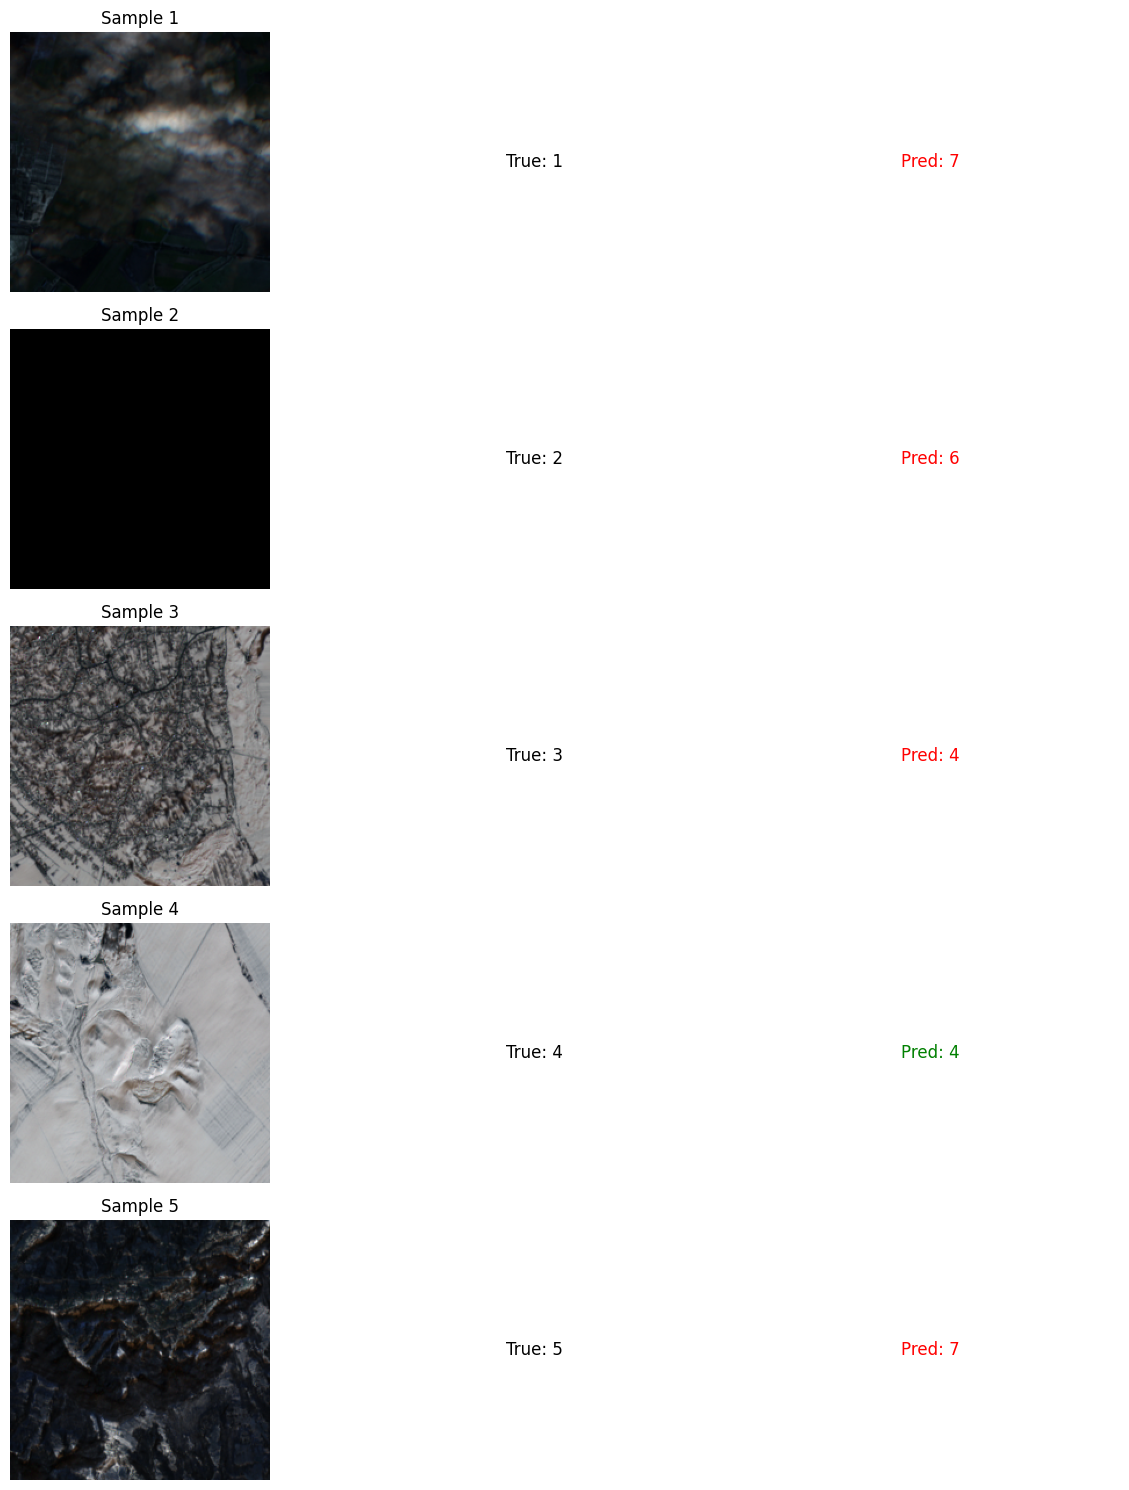

✅ Visualization saved

✅ DONE!


In [ ]:
try:
    # Load best model
    best_model = ClassificationTask.load_from_checkpoint(
        checkpoint_callback.best_model_path,
        model_factory="EncoderDecoderFactory",
    )
    best_model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    best_model = best_model.to(device)

    # Get test batch
    test_loader = datamodule.test_dataloader()
    batch = next(iter(test_loader))

    # Extract images and labels
    images = batch["image"]
    labels = batch["label"]

    # Move to device
    images = images.to(device)

    # Get predictions
    with torch.no_grad():
        # Pass the tensor directly
        outputs = best_model(images)
        preds = torch.argmax(outputs.output, dim=1).cpu().numpy()

    # Visualize
    fig, axes = plt.subplots(5, 3, figsize=(12, 15))
    class_names = [str(i+1) for i in range(NUM_CLASSES)]

    num_samples = min(5, len(labels))
    for i in range(num_samples):
        # Get image (use first 3 bands for RGB visualization)
        img = images[i].cpu().permute(1, 2, 0).numpy()

        # Simple normalization for display only
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)

        if img.shape[2] > 3:
            img = img[:, :, [2, 1, 0]]  # RGB

        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Sample {i+1}")
        axes[i, 0].axis('off')

        axes[i, 1].text(0.5, 0.5, f"True: {class_names[labels[i]]}",
                       ha='center', va='center', fontsize=12)
        axes[i, 1].axis('off')

        color = 'green' if labels[i] == preds[i] else 'red'
        axes[i, 2].text(0.5, 0.5, f"Pred: {class_names[preds[i]]}",
                       ha='center', va='center', fontsize=12, color=color)
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'predictions.png'), dpi=150)
    plt.show()

    print("✅ Visualization saved")

except Exception as e:
    print(f"⚠️ Could not visualize: {e}")

print("\n✅ DONE!")